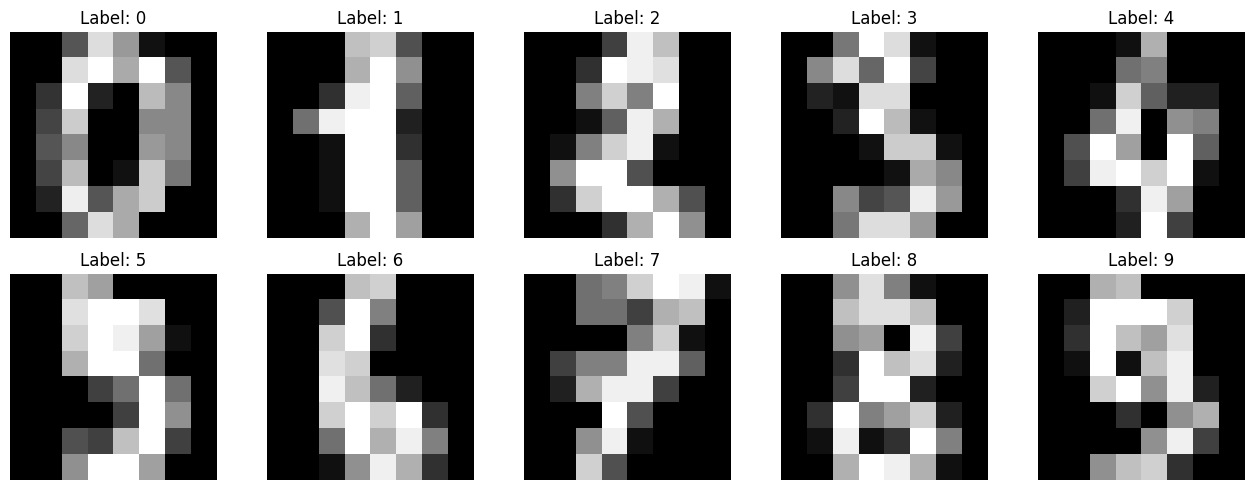

In [6]:
import torch
import numpy as np
from torch import nn
from torch import optim

import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data.astype(np.float32)
y = digits.target.astype(np.int64)

fig, ax = plt.subplots(figsize=(13, 5), nrows=2, ncols=5)
for i in range(10):
    ax[i // 5, i % 5].imshow(X[i].reshape(8, 8), cmap="gray")
    ax[i // 5, i % 5].set_title(f"Label: {y[i]}")
    ax[i // 5, i % 5].axis("off")
fig.tight_layout()


In [3]:
from sklearn.model_selection import train_test_split

# 우선 8:2 로 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# 2를 다시 1:1로 나누기
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify = y_temp)

# 표준화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [4]:
# 모든 데이터를 텐서로 변환
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid)
y_valid_t = torch.from_numpy(y_valid)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

# Pytorch TensorDataset에 넣어주기
from torch.utils.data import TensorDataset

train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_valid_t, y_valid_t)
test_ds = TensorDataset(X_test_t, y_test_t)

# TensorDataset을 DataLoader로 변환
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [5]:
for idx, batch in enumerate(train_loader):
    print(idx, batch)
    print(len(batch[1]))
    break

0 [tensor([[ 0.0000, -0.3305, -1.0952,  ..., -0.8197, -0.5045, -0.1936],
        [ 0.0000, -0.3305, -1.0952,  ..., -1.1588, -0.5045, -0.1936],
        [ 0.0000, -0.3305, -1.0952,  ..., -1.1588, -0.5045, -0.1936],
        ...,
        [ 0.0000, -0.3305, -0.0347,  ..., -0.4807, -0.5045, -0.1936],
        [ 0.0000, -0.3305,  0.6016,  ...,  1.3843,  0.7189, -0.1936],
        [ 0.0000, -0.3305,  0.8137,  ...,  1.5538,  3.4106,  2.7044]]), tensor([4, 4, 8, 5, 4, 0, 9, 0, 5, 8, 9, 2, 6, 0, 8, 4, 5, 5, 0, 1, 6, 3, 0, 9,
        2, 0, 2, 3, 9, 1, 3, 2])]
32


In [7]:
# TODO
# 3. Multi-Layer Perceptron 구현하기
# 가장 기본적인 MultiLayer Perceptron을 구현해주세요.
# 계층은 총 3개입니다.
# 입력표현 -> 은닉표현1 -> 은닉표현2 -> 출력표현
# 입력값들은 `nn.Linear`를 통과한 뒤 ReLU를 거치고 Dropout을 거치도록 설계해주세요.
# 제가 정의해준 `__init__` 안의 인자에 맞춰서 작업해주세요 :)

class MLP(nn.Module):
    def __init__(self,
                 input_dim: int,
                 num_classes: int,
                 hidden_dims=(128, 64),
                 dropout=0.2):
        super().__init__()
        h1, h2 = hidden_dims

        self.net = nn.Sequential(
            # 은닉1
            nn.Linear(input_dim, h1),
            # 활성화 + Dropout
            nn.ReLU(),
            nn.Dropout(dropout),

            # 은닉2 (입력 차원은 은닉1의 출력차원)
            nn.Linear(h1, h2),
            # 활성화 + Dropout
            nn.ReLU(),
            nn.Dropout(dropout),

            # 출력
            nn.Linear(h2, num_classes)
        )


    def forward(self, x):
        return self.net(x)

In [8]:
# 정답코드
# 4. DataLoader, Model, Optimizer가 주어졌을 때
# 학습데이터에 대해 model을 업데이트하는 코드를 작성해주세요.
def train_one_epoch(model, loader, optimizer, device):
    # 모델이 학습모드로 들어가게 설정해야합니다.
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        # 데이터를 가속화기기로 보내주세요.
        xb, yb = xb.to(device), yb.to(device)

        # 위에서 배운 파라미터 업데이트 방식을 구현해주세요.
        # 1. 모델의 출력 만들어주기
        # 2. 미분값 지워주기 (zero_grad)
        # 3. Loss 계산해주기: loss는 cross_entropy를 사용해주세요
        #   - https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
        # 4. 3에서 계산한 Loss를 기준으로 역전파를 수행합니다.
        # 5. 파라미터 업데이트를 진행해주세요
        optimizer.zero_grad()
        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        optimizer.step()

        # 파라미터 업데이트가 끝났으면 몇 가지를 기록해줍니다.
        # 1. batch당 로스 계산 (running_loss에 업데이트)
        # 2. 예측된 클래스 계산 (`preds`)
        # 3. batch 내 정확도 계산 (batch 내에서 정답개수를 correct에 추가)
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    # 위에서 잘 계산된 값들을 정리해서 반환합니다.
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

# 정답코드
# 5. 이번에는 모델과 검증/테스트데이터가 입력으로 들어왔을 때 정확도를 계산해주는 코드를 작성해주세요.
def evaluate(model, loader, device):
    # 모델이 추론할 때는 추론모드로 설정해주어야합니다.
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    # 미분그래프를 생성하지 않도록 컨텍스트를 생성해주셔야합니다.
    with torch.no_grad():
        for xb, yb in loader:
            # 데이터로더에서 나온 배치를 `device`로 보내주세요.
            xb, yb = xb.to(device), yb.to(device)

            # 위에서 한 것과 비슷하게
            # 모델의 출력값을 만들어 `logits`에 담고
            # 현재 출력값 `logits`와 `yb` 사이의 Cross Entropy를 계산해주세요.
            logits = model(xb)
            loss = torch.nn.functional.cross_entropy(logits, yb)

            # 이번에도 다음을 기록해줍니다.
            # 1. batch당 로스 계산 (running_loss에 update)
            # 2. 예측된 클래스 계산 (`preds`)
            # 3. batch 내 정확도 계산 (batch 내에서 정답개수를 correct에 추가)
            # 4. 후에 정확한 분류성능을 보기 위해 prediction 값들도 전부 기록해줍니다.
            #  - all_preds, all_targets에 append해줍니다.
            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.append(preds.cpu())
            all_targets.append(yb.cpu())

    # 위에서 잘 계산된 값들을 정리해서 반환합니다.
    avg_loss = running_loss / total
    acc = correct / total
    preds_cat = torch.cat(all_preds).numpy()
    targets_cat = torch.cat(all_targets).numpy()
    return avg_loss, acc, preds_cat, targets_cat

In [11]:
# 모든 것을 하나로!
# 여러분이 코드를 잘 짰다면 아래 코드가 잘 작동할겁니다!
# 에러가 뜬다면 에러메시지를 확인해서 잘 구현되도록 맞춰주세요.
import os
import math
import time

from sklearn.metrics import classification_report, confusion_matrix

# device = torch.device("cuda")
model = MLP(
    input_dim=64,
    num_classes=10,
    hidden_dims=(128, 64),
    dropout=0.2
).to(device)

# 이번에는 지난 과제2에서 배웠던 Adam을 사용해봅시다.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

best_val_loss = math.inf
best_val_acc = -1.0
epochs_no_improve = 0

checkpoint_path = "model.ckpt"
earlystop_patience = 5

train_losses, train_accs = [], []
valid_losses, valid_accs = [], []
for epoch in range(1, 201):
    t0 = time.time()
    # 여러분이 정의한 `train_one_epoch`와 `evaluate`입니다.
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc, _, _ = evaluate(model, valid_loader, device)
    valid_losses.append(val_loss)
    valid_accs.append(val_acc)

    dt = time.time() - t0
    print(
        f"Epoch {epoch:03d} | "
        f"train loss {train_loss:.4f} acc {train_acc*100:5.2f}% | "
        f"val loss {val_loss:.4f} acc {val_acc*100:5.2f}% | "
        f"{dt:.1f}s"
    )

    # 🌟 개선 시 체크포인트 저장
    improved = (val_loss < best_val_loss) or (val_acc > best_val_acc)
    if improved:
        best_val_loss = min(best_val_loss, val_loss)
        best_val_acc = max(best_val_acc, val_acc)
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_dim': 64,
            'num_classes': 10,
        }, checkpoint_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # 조기 종료
    if epochs_no_improve >= earlystop_patience:
        print(f"Early stopping at epoch {epoch} (no improve {earlystop_patience})")
        break

# 베스트 모델 로드 후 테스트 평가
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    print(f"Loaded best checkpoint: val_best_acc={best_val_acc*100:.2f}% val_best_loss={best_val_loss:.4f}")

test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, device)
print("\n==== Test Result ====")
print(f"Test loss: {test_loss:.4f}")
print(f"Test acc : {test_acc*100:.2f}%")

# 분류 리포트 / 혼동행렬
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

TypeError: train_one_epoch() missing 1 required positional argument: 'device'